In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
# !pip install nltk
# !pip install wordcloud

In [2]:
import warnings
warnings.filterwarnings("ignore")
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer    # lemmatize
from wordcloud import WordCloud, STOPWORDS
import string
import json

In [3]:
from sklearn.model_selection import train_test_split
random_state=42
import os
import csv
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

stopwords_manual = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
STOP_WORDS = stopwords.words('english')
# STOP_WORDS = STOP_WORDS + stopwords_manual

stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.remove("not")
stopwords.remove("no")
stopwords.add(" ")
# len(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
model_name='my_model.h5'
tokenizer_model= 'tokenizer_model.json'

## PreProcess and Tokenization functions

In [6]:
###-------------------------------- preprocessing text ------------------------------###

# Expanding Constractions

def text_preprocess(x):
    x = str(x).lower()
    x = x.replace('%',' percent').replace('₹',' rupee').replace('$',' dollar').replace('€',' euro')\
                                .replace(',000,000','m').replace('000','k').replace('′',"'").replace("’","'")\
                                .replace("won't","will not").replace("can't",'can not').replace("shouldn't","should not")\
                                .replace("what's",'"what is"').replace("that's",'that is').replace("he's","he is")\
                                .replace("she's","she is").replace("it's","it is").replace("'ve"," have").replace("'re"," are")\
                                .replace("'ll"," will").replace("i'm","i am").replace("n't", " not")
    x = re.sub(r'([0-9]+)000000',r'\1m',x)
    x = re.sub(r'([0-9]+)000',r'\1k',x)

    return x

def extract_features(df):
    df['Summary'] = df['Summary'].fillna("").apply(text_preprocess)

    return df

# Removal of URLs

def remove_urls(text):

    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    return url_pattern.sub(r'', text)

# Removal of HTML tags

def remove_html(text):

    html_pattern = re.compile('<.*?>')

    return html_pattern.sub(r'', text)

# Spiliting words

def word_tokenize(txt):

    tokens = re.findall("[\w']+", txt)

    return tokens

# Removal Stopwords

def remove_stopwords(lst):

    stop=stopwords
    new_lst=[]
    for i in lst:

        if i not in stop:
            new_lst.append(i)

    return new_lst

def remove_extrawords(lst):

    stop=['href','lt','gt','ii','iii','ie','quot','com','U']   ## This all words are most repeated words as we observed in WordCloud and it does not make any sense
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)

    return new_lst

# Removal of punctuations

def remove_punctuations(lst):
    new_lst=[]
    for i in lst:
        for j in  string.punctuation:
            i=i.replace(j,'')
        new_lst.append(i)
    return new_lst

# Removal of Numbers

def remove_numbers(lst):
    nodig_lst=[]
    new_lst=[]

    for i in  lst:
        for j in  string.digits:
            i=i.replace(j,'')
        nodig_lst.append(i)
    for i in  nodig_lst:
        if  i!='':
            new_lst.append(i)
    return new_lst

# Lemmatzation of Data

lemmatizer = WordNetLemmatizer()
def lemmatzation(lst):
    new_lst=[]
    for i in lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i)
    return new_lst

##--------------------------------------------------------------------##
def preprocess(df):

  # data
  if 'Summary' not in list(df.columns):
    df['Summary'] = df['Headline'] + ' ' + df['Description']
    df.drop(columns=['Headline', 'Description'],inplace=True)
    df.rename(columns={'Class Index':'Labels'},inplace=True)

  # Extract Features
  df = extract_features(df)

  # URLs
  df.Summary=df.Summary.apply(remove_urls)

  # HTML tags
  df.Summary=df.Summary.apply(remove_html)

  # Split word
  df.Summary=df.Summary.apply(word_tokenize)

  # Stopwords & Extrawords
  df.Summary=df.Summary.apply(remove_stopwords)
  df.Summary=df.Summary.apply(remove_extrawords)

  # Punctuation symbols
  df.Summary=df.Summary.apply(remove_punctuations)

  # Numbers
  df.Summary=df.Summary.apply(remove_numbers)

  # Lemmatzation
  df.Summary=df.Summary.apply(lemmatzation)

  # label
  cat={'politics':0, 'sport':1, 'business':2, 'tech':3}
  df['Labels'] = df['Labels'].apply(lambda x : cat[x])

  # split into X, y
  X_df=df['Summary']
  y_df=df['Labels']

  print("token features...")


  return df,X_df,y_df


In [7]:
#----------------------X-----------------------
#tokenizing

def fit_tokenizer(data_sentences, num_words, oov_token):
    # instantiate the Tokenizer class
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(data_sentences)

    return tokenizer

# sequence & padding

def seq_and_pad(sentences, tokenizer, padding, maxlen):
    # convert training sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences,
                                     maxlen=maxlen,
                                     padding=padding,
                                     truncating='post')

    return padded_sequences



## Setting hyperparameters

In [8]:
# the maximum number of words to keep, based on word frequency
NUM_WORDS = 20000

# dimension of the dense embedding that will be used in the embedding layer of the model
EMBEDDING_DIM = 16

# maximum length of all sequences
MAXLEN = 40

# padding strategy
PADDING = 'post'

# token to replace out-of-vocabulary words during text_to_sequence() calls
OOV_TOKEN = "<OOV>"


## Load Model

In [9]:
model = tf.keras.models.load_model(model_name)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 16)            320000    
                                                                 
 bidirectional (Bidirection  (None, 40, 64)            12544     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 343044 (1.31 MB)
Trainable params: 343044 (1.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Load Dataset

In [11]:
# test=pd.read_csv('./test_edited.csv')
test=pd.read_csv('./test.csv')



## Preprocess and tokinze data

In [12]:
test_df,X_test_df,y_test_df=preprocess(test)

# fit the Tokenizer for the test dataset

# Load training tokenizer
with open(tokenizer_model) as f:
   tt = json.load(f)

# tokenizer = tokenizer_from_json('saved_tokenizer.json')
tokenizer = tokenizer_from_json(tt)

# get word_index
test_word_index = tokenizer.word_index

X_test = seq_and_pad(X_test_df, tokenizer, PADDING, MAXLEN)
y_test=y_test_df

print(f"Number of words in the test vocabulary: {len(test_word_index)}\n")
print(f"Shape of padded testing sequences: {X_test.shape}\n")


token features...
Number of words in the test vocabulary: 56718

Shape of padded testing sequences: (7600, 40)



## Prediction

In [13]:
# make predictions (categories) on the test data
y_pred = model.predict(X_test)

# Get the class with the highest probability for each input sentence
predicted_classes = y_pred.argmax(axis=1)
print(f'Predicted classes:\n\n {predicted_classes}')


238/238 [==============================] - 5s 13ms/step
Predicted classes:

 [2 3 3 ... 1 2 2]


## reports

238/238 [==============================] - 6s 13ms/step - loss: 0.3317 - accuracy: 0.9022
Test Loss: 0.3317, Test Accuracy: 0.9022
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.95      0.96      0.96      1900
           2       0.87      0.88      0.87      1900
           3       0.87      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



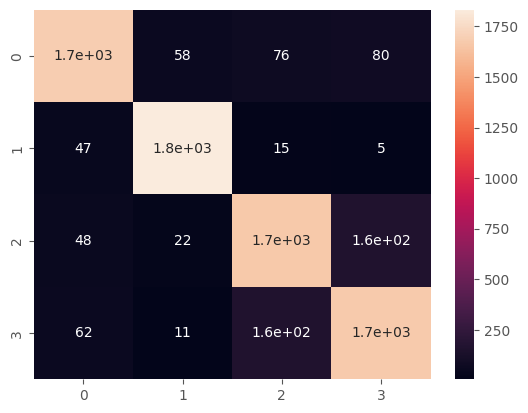

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test.values, predicted_classes)
sns.heatmap(cm, annot=True)
plt.savefig('confusion.png')

print(classification_report(y_test, predicted_classes))